## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil
from IPython.display import clear_output

In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.2

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.0001
learn_opts.batch_size = 64

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
myopts.random_stratify = True
myopts.cache_dir = '/tmp/moldata'
myopts.clear_cache = True               # If you repeat experiments within the same dataset version, set to False
myopts.train_keys = 'keys/keys_refined'
myopts.kinase_list = 'keys/kinase_list'
myopts.dataset_version = 3              # <- The newest is 3, still 1 and 2 are acceptible
myopts.cpu_count = 10

In [7]:
assert myopts.dataset_version in [1, 2, 3]
_ver = myopts.dataset_version
if _ver == 1:
    import dataset as ds
elif _ver == 2:
    import dataset2 as ds
else:
    import dataset3 as ds

### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))

        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify)

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(202, 50, 75)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(202, 50)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

4btk ... caching


In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

### Start Learning

number of parameters :  214727


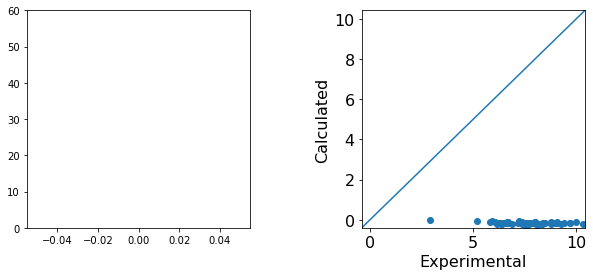

rmse: 7.867, mae: 7.744, r2: -0.379, rho: -0.277
--- Too many off-valued molecules ---

Epoch: 0	Lapse: 4.5s	Losses: (56.487, 61.890)	Best: (56.487, 61.890)


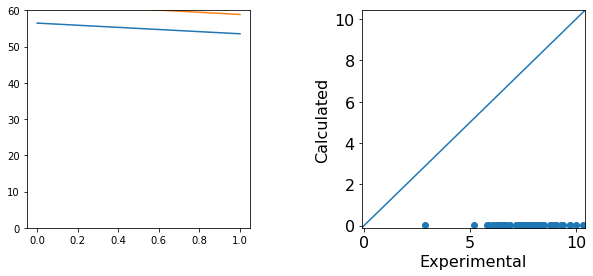

rmse: 7.672, mae: 7.550, r2: -0.169, rho: -0.173
--- Too many off-valued molecules ---

Epoch: 1	Lapse: 4.7s	Losses: (53.536, 58.865)	Best: (53.536, 58.865)


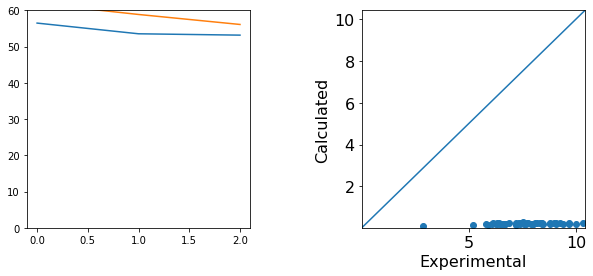

rmse: 7.491, mae: 7.368, r2: 0.497, rho: 0.332
--- Too many off-valued molecules ---

Epoch: 2	Lapse: 4.7s	Losses: (53.163, 56.108)	Best: (53.163, 56.108)


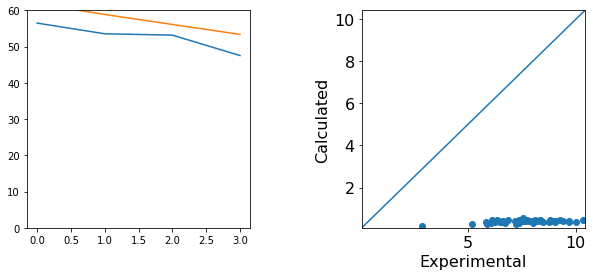

rmse: 7.305, mae: 7.182, r2: 0.466, rho: 0.323
--- Too many off-valued molecules ---

Epoch: 3	Lapse: 5.0s	Losses: (47.533, 53.368)	Best: (47.533, 53.368)


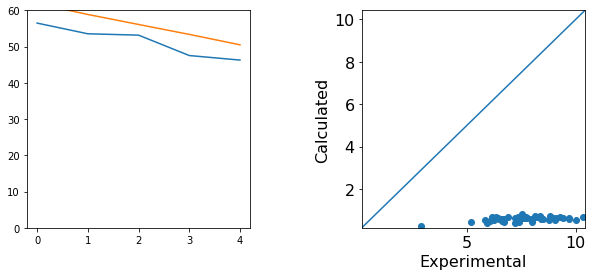

rmse: 7.106, mae: 6.982, r2: 0.453, rho: 0.308
--- Too many off-valued molecules ---

Epoch: 4	Lapse: 4.9s	Losses: (46.281, 50.496)	Best: (46.281, 50.496)


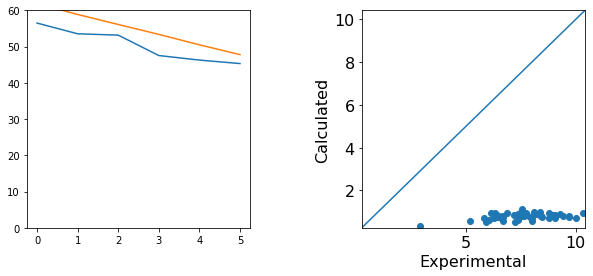

rmse: 6.912, mae: 6.787, r2: 0.437, rho: 0.296
--- Too many off-valued molecules ---

Epoch: 5	Lapse: 4.9s	Losses: (45.318, 47.781)	Best: (45.318, 47.781)


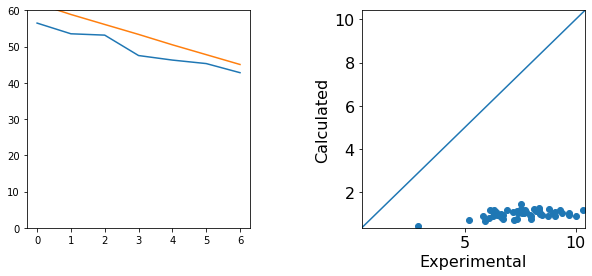

rmse: 6.713, mae: 6.587, r2: 0.431, rho: 0.294
--- Too many off-valued molecules ---

Epoch: 6	Lapse: 4.8s	Losses: (42.802, 45.065)	Best: (42.802, 45.065)


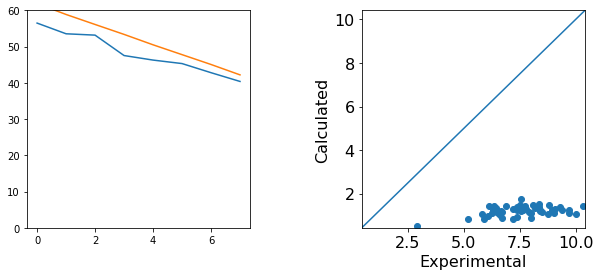

rmse: 6.496, mae: 6.368, r2: 0.428, rho: 0.292
--- Too many off-valued molecules ---

Epoch: 7	Lapse: 4.8s	Losses: (40.386, 42.199)	Best: (40.386, 42.199)


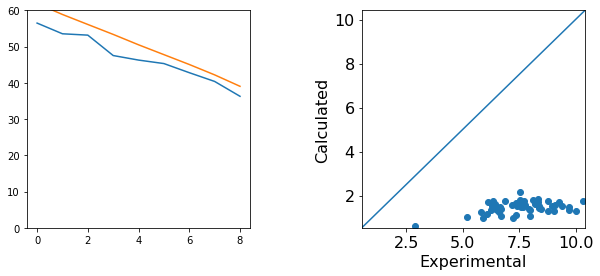

rmse: 6.248, mae: 6.118, r2: 0.427, rho: 0.292
--- Too many off-valued molecules ---

Epoch: 8	Lapse: 5.3s	Losses: (36.287, 39.043)	Best: (36.287, 39.043)


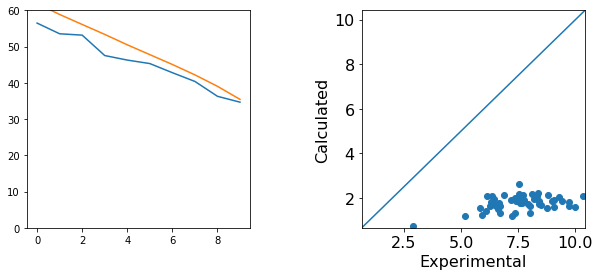

rmse: 5.953, mae: 5.819, r2: 0.431, rho: 0.300
--- Too many off-valued molecules ---

Epoch: 9	Lapse: 5.3s	Losses: (34.664, 35.441)	Best: (34.664, 35.441)


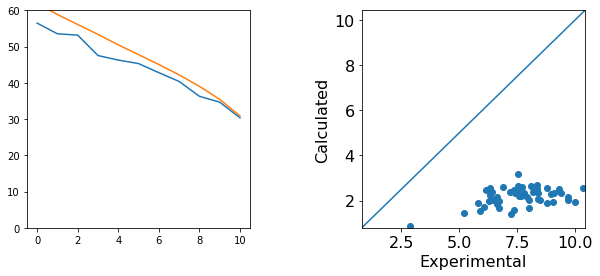

rmse: 5.557, mae: 5.416, r2: 0.442, rho: 0.300
--- Too many off-valued molecules ---

Epoch: 10	Lapse: 5.2s	Losses: (30.345, 30.877)	Best: (30.345, 30.877)


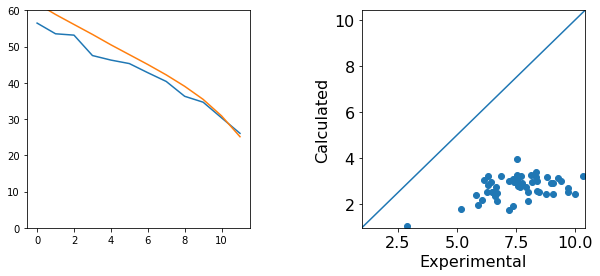

rmse: 5.013, mae: 4.862, r2: 0.453, rho: 0.303
--- Too many off-valued molecules ---

Epoch: 11	Lapse: 5.0s	Losses: (26.059, 25.132)	Best: (26.059, 25.132)


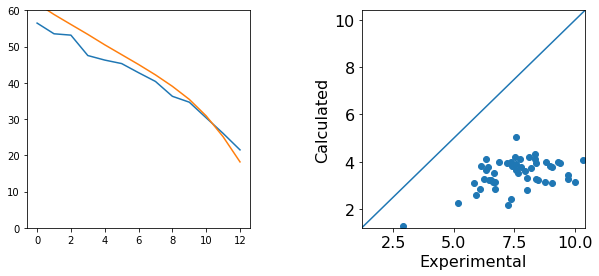

rmse: 4.265, mae: 4.090, r2: 0.466, rho: 0.314
--- Too many off-valued molecules ---

Epoch: 12	Lapse: 4.9s	Losses: (21.499, 18.188)	Best: (21.499, 18.188)


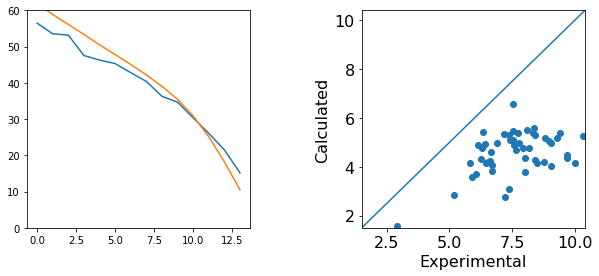

rmse: 3.235, mae: 2.997, r2: 0.475, rho: 0.331
--- Too many off-valued molecules ---

Epoch: 13	Lapse: 5.0s	Losses: (15.161, 10.468)	Best: (15.161, 10.468)


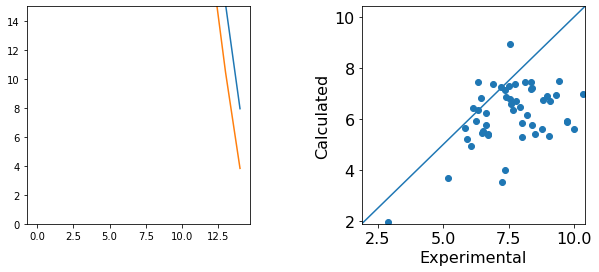

rmse: 1.956, mae: 1.565, r2: 0.448, rho: 0.297
--- Too many off-valued molecules ---

Epoch: 14	Lapse: 5.2s	Losses: (7.942, 3.824)	Best: (7.942, 3.824)


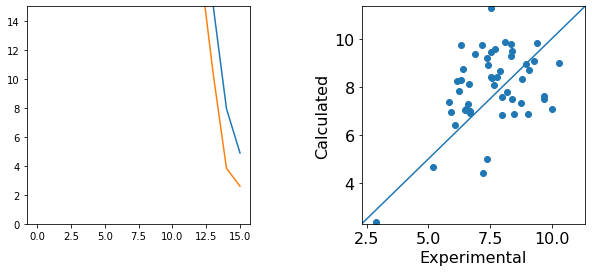

rmse: 1.611, mae: 1.339, r2: 0.440, rho: 0.277


4ivc,10.000,2.930
4gfm,7.220,2.803


Epoch: 15	Lapse: 5.1s	Losses: (4.883, 2.595)	Best: (4.883, 2.595)
Epoch: 16	Lapse: 5.4s	Losses: (5.044, 3.347)	Best: (4.883, 2.595)


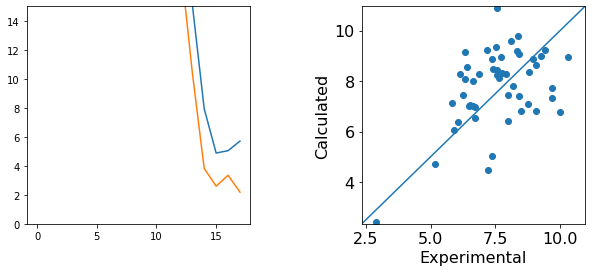

rmse: 1.478, mae: 1.208, r2: 0.475, rho: 0.322


4ivc,10.000,3.220
4gfm,7.220,2.746


Epoch: 17	Lapse: 5.1s	Losses: (5.706, 2.184)	Best: (4.883, 2.184)
Epoch: 18	Lapse: 5.5s	Losses: (5.116, 2.205)	Best: (4.883, 2.184)
Epoch: 19	Lapse: 4.9s	Losses: (4.979, 3.123)	Best: (4.883, 2.184)
Epoch: 20	Lapse: 5.2s	Losses: (3.911, 3.160)	Best: (3.911, 2.184)
Epoch: 21	Lapse: 5.0s	Losses: (4.191, 2.466)	Best: (3.911, 2.184)


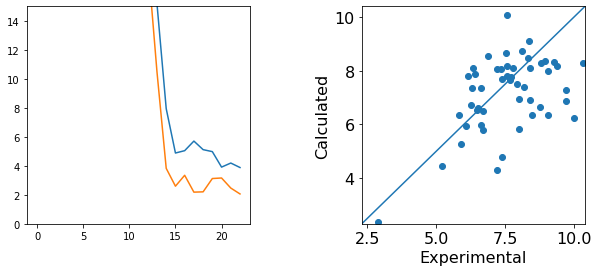

rmse: 1.435, mae: 1.112, r2: 0.495, rho: 0.373


4ivc,10.000,3.779
4gfm,7.220,2.929
4fk6,9.700,2.840
4uja,9.050,2.706
6g37,7.370,2.592


Epoch: 22	Lapse: 5.1s	Losses: (3.882, 2.059)	Best: (3.882, 2.059)


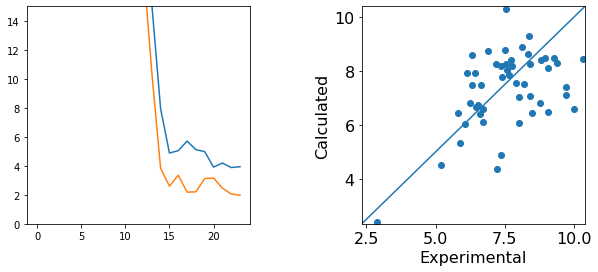

rmse: 1.404, mae: 1.113, r2: 0.499, rho: 0.367


4ivc,10.000,3.394
4gfm,7.220,2.849
4uja,9.050,2.586
4fk6,9.700,2.578


Epoch: 23	Lapse: 5.5s	Losses: (3.938, 1.971)	Best: (3.882, 1.971)
Epoch: 24	Lapse: 5.3s	Losses: (4.214, 1.979)	Best: (3.882, 1.971)
Epoch: 25	Lapse: 5.2s	Losses: (3.622, 1.981)	Best: (3.622, 1.971)
Epoch: 26	Lapse: 5.2s	Losses: (3.963, 2.017)	Best: (3.622, 1.971)
Epoch: 27	Lapse: 5.0s	Losses: (3.828, 2.049)	Best: (3.622, 1.971)
Epoch: 28	Lapse: 5.1s	Losses: (3.424, 2.092)	Best: (3.424, 1.971)
Epoch: 29	Lapse: 5.1s	Losses: (4.364, 1.999)	Best: (3.424, 1.971)


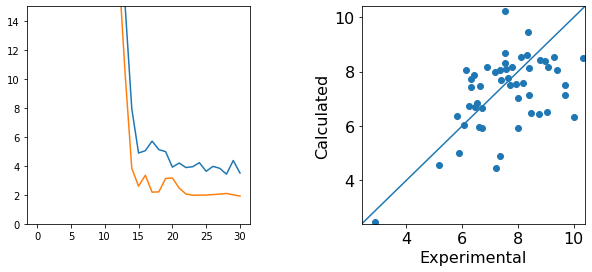

rmse: 1.383, mae: 1.086, r2: 0.518, rho: 0.398


4ivc,10.000,3.657
4gfm,7.220,2.768
4fk6,9.700,2.573
4uja,9.050,2.546


Epoch: 30	Lapse: 5.0s	Losses: (3.503, 1.914)	Best: (3.424, 1.914)


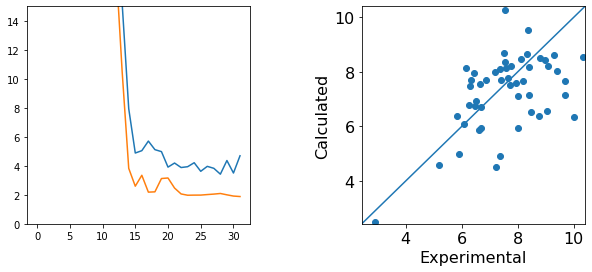

rmse: 1.371, mae: 1.074, r2: 0.524, rho: 0.415


4ivc,10.000,3.672
4gfm,7.220,2.726
4fk6,9.700,2.537


Epoch: 31	Lapse: 5.0s	Losses: (4.691, 1.881)	Best: (3.424, 1.881)
Epoch: 32	Lapse: 5.0s	Losses: (4.255, 2.060)	Best: (3.424, 1.881)
Epoch: 33	Lapse: 4.9s	Losses: (3.752, 2.084)	Best: (3.424, 1.881)
Epoch: 34	Lapse: 5.0s	Losses: (3.773, 2.056)	Best: (3.424, 1.881)


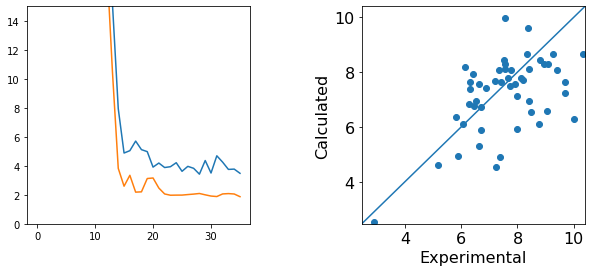

rmse: 1.368, mae: 1.067, r2: 0.533, rho: 0.424


4ivc,10.000,3.695
4gfm,7.220,2.684
5wal,8.770,2.662


Epoch: 35	Lapse: 5.0s	Losses: (3.483, 1.871)	Best: (3.424, 1.871)


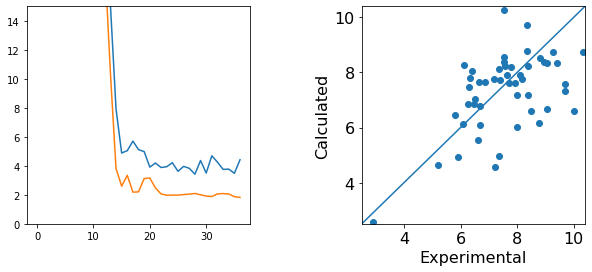

rmse: 1.350, mae: 1.064, r2: 0.535, rho: 0.417


4ivc,10.000,3.403
4gfm,7.220,2.633
5wal,8.770,2.586


Epoch: 36	Lapse: 4.8s	Losses: (4.415, 1.822)	Best: (3.424, 1.822)
Epoch: 37	Lapse: 4.9s	Losses: (3.155, 1.862)	Best: (3.155, 1.822)
Epoch: 38	Lapse: 4.9s	Losses: (3.426, 1.919)	Best: (3.155, 1.822)
Epoch: 39	Lapse: 5.0s	Losses: (3.032, 1.926)	Best: (3.032, 1.822)
Epoch: 40	Lapse: 5.0s	Losses: (3.144, 1.980)	Best: (3.032, 1.822)
Epoch: 41	Lapse: 5.1s	Losses: (3.316, 2.113)	Best: (3.032, 1.822)
Epoch: 42	Lapse: 5.1s	Losses: (3.543, 2.141)	Best: (3.032, 1.822)
Epoch: 43	Lapse: 4.9s	Losses: (3.198, 2.094)	Best: (3.032, 1.822)
Epoch: 44	Lapse: 4.8s	Losses: (4.078, 2.029)	Best: (3.032, 1.822)
Epoch: 45	Lapse: 5.0s	Losses: (3.030, 1.969)	Best: (3.030, 1.822)
Epoch: 46	Lapse: 5.5s	Losses: (3.175, 1.948)	Best: (3.030, 1.822)
Epoch: 47	Lapse: 5.3s	Losses: (3.052, 1.954)	Best: (3.030, 1.822)
Epoch: 48	Lapse: 5.7s	Losses: (3.794, 1.967)	Best: (3.030, 1.822)
Epoch: 49	Lapse: 5.3s	Losses: (3.496, 1.986)	Best: (3.030, 1.822)
Epoch: 50	Lapse: 5.2s	Losses: (2.973, 2.070)	Best: (2.973, 1.822)
Epoch: 51	

In [ ]:
CLEAR_OUTPUT_WHEN_UPDATE = False
SHOW_VERY_BAD_MOLS = True

model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()
best_train_loss, best_val_loss = np.inf, np.inf

Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        write_results_to_csv(L[0], X, y, np.abs(X-y), epoch)

        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))